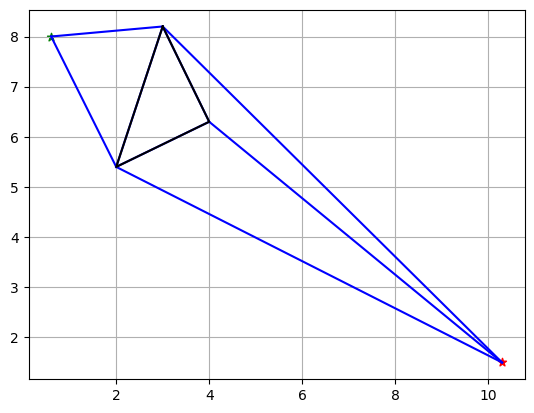

In [1]:
import csv
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from math import sqrt
import heapq

env_filename = "env_0.csv"
vis_filename = "visibility_graph_env_0.csv"

def construct_map(env_filename, vis_filename, path=None, vis=True):

    # Extract points and obstacles from map
    map = {}
    vertices = {}
    nodes = []
    with open(env_filename, "r") as f:
        for count, line in enumerate(f):
            if count != 0:
                idx, x, y = line.strip().split(",")
                idx = int(idx)
                x = float(x)
                y = float(y)

                if idx not in map:
                    map[idx] = []
                map[idx].append([x, y])

                if count == 2:
                    first_obj_idx = idx
                goal_idx = idx

                if count not in vertices:
                    vertices[count-1] = []
                vertices[count-1].append([x, y])

                nodes.append([x, y])

    # Extract visibility lines
    vis_lines = []
    with open(vis_filename, "r") as f:
        for count, line in enumerate(f):
            if count != 0:
                idx1, idx2 = line.strip().split(",")
                vis_lines.append((int(idx1), int(idx2)))

    # Plot start and goal points
    start_point = map[0][0]
    goal_point = map[goal_idx][0]
    plt.scatter(start_point[0], start_point[1], color='green', marker='*')
    plt.scatter(goal_point[0], goal_point[1], color='red', marker='*')

    # Draw visibility lines
    connections = []
    for idx1, idx2 in vis_lines:
        points1 = vertices[idx1]
        points2 = vertices[idx2]
        connections.append([points1[0], points2[0]])
        for p1 in points1:
            for p2 in points2:
                plt.plot([p1[0], p2[0]], [p1[1], p2[1]], color='blue')

    # Draw obstacles in black
    for obstacle_idx in range(first_obj_idx, goal_idx):
        obstacle = map[obstacle_idx]
        x_coords, y_coords = zip(*obstacle)
        x_coords = list(x_coords) + [x_coords[0]]
        y_coords = list(y_coords) + [y_coords[0]]
        plt.plot(x_coords, y_coords, color='black')

    # Plot path from start to goal if provided
    if path:
        path_pairs = [[path[i], path[i + 1]] for i in range(len(path) - 1)]
        for start, end in path_pairs:
            start_coords = vertices[start]
            end_coords = vertices[end]
            x_coords = [start_coords[0][0], end_coords[0][0]]
            y_coords = [start_coords[0][1], end_coords[0][1]]
            plt.plot(x_coords, y_coords, color='red', linestyle='-', linewidth=2, label="Path Segment")

    if vis == True:
        plt.grid(True)
        plt.show()

    return nodes, connections


nodes, connections = construct_map(env_filename, vis_filename)


In [2]:
def reconstruct_path(came_from, current, nodes):
    total_path = [nodes.index(current)]
    while nodes.index(current) in came_from.keys():
        current = came_from[nodes.index(current)]
        total_path.insert(0, nodes.index(current))
    return total_path

def heuristic(cell_1, cell_2):
    return sqrt((cell_1[0] - cell_2[0])**2 + (cell_1[1] - cell_2[1])**2)

def get_neighbours(node, connections):
    neighbours = []
    for c in connections:
        if c[0] == node:
            neighbours.append(c[1])
        if c[1] == node:
            neighbours.append(c[0])
    
    return neighbours

In [3]:
def A_star(nodes, connections):

    # Initialise start and goal
    start = nodes[0]
    goal = nodes[len(nodes)-1]

    # Initialise open and closed sets
    open_set = [start]
    came_from = {}
    g_score = {nodes.index(start): 0}
    f_score = {nodes.index(start): g_score[0] + heuristic(start, goal)}
    for i in range(1, len(nodes)):
        g_score[i] = float('inf')
        f_score[i] = float('inf')
    
    while open_set:
        # Node in open set with lowest f_score
        current = min(open_set, key=lambda x: f_score[nodes.index(x)])

        # If goal is reach return the reconstructed path
        if current == goal:
            return reconstruct_path(came_from, current, nodes)

        open_set.remove(current)

        # Get the neighbours of the current node
        neighbours = get_neighbours(current, connections)
        
        for n in neighbours:
            tent_g_score = g_score[nodes.index(current)] + heuristic(current, n)
            
            # If we've found a better path to the neighbour
            if tent_g_score < g_score[nodes.index(n)]:
                came_from[nodes.index(n)] = current
                g_score[nodes.index(n)] = tent_g_score
                f_score[nodes.index(n)] = g_score[nodes.index(n)] + heuristic(n, goal)

                # Add neighbour to open set if not already in it
                if n not in open_set:
                    open_set.append(n)
    
    # If we go through the open set and don't find the goal, return 'Failed'
    return 'Failed'


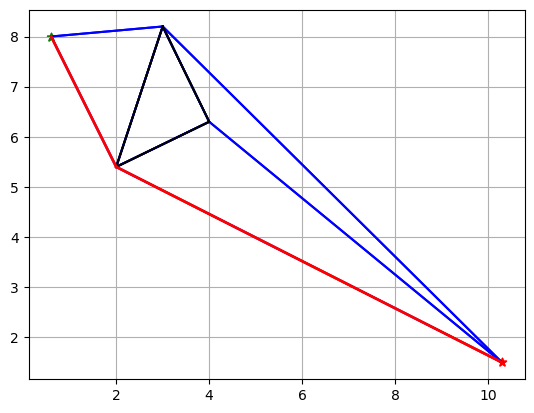

In [4]:
nodes, connections = construct_map(env_filename, vis_filename, vis=False)
path = A_star(nodes, connections)
nodes, connections = construct_map(env_filename, vis_filename, path)

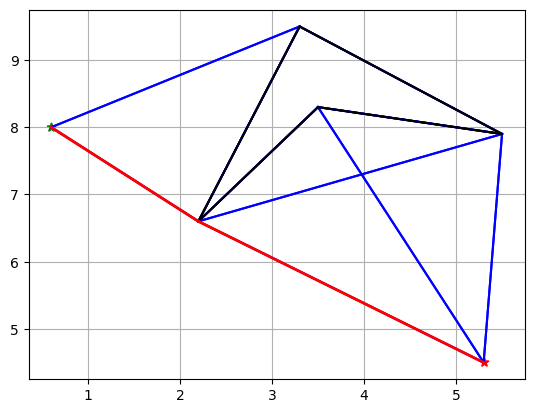

In [4]:
env_filename = "env_1.csv"
vis_filename = "visibility_graph_env_1.csv"
nodes, connections = construct_map(env_filename, vis_filename, vis=False)
path = A_star(nodes, connections)
nodes, connections = construct_map(env_filename, vis_filename, path)

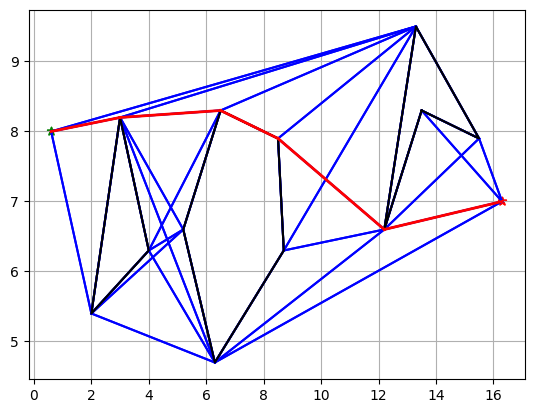

In [5]:
env_filename = "env_2.csv"
vis_filename = "visibility_graph_env_2.csv"
nodes, connections = construct_map(env_filename, vis_filename, vis=False)
path = A_star(nodes, connections)
nodes, connections = construct_map(env_filename, vis_filename, path)

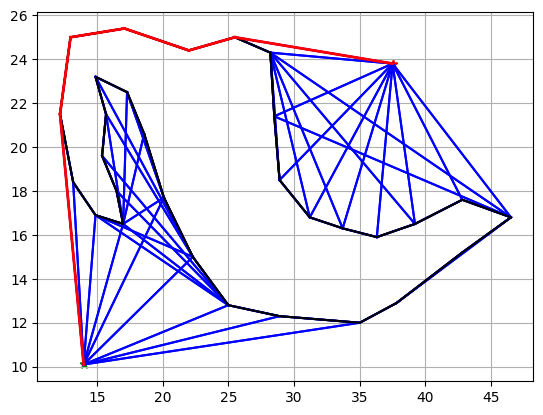

In [6]:
env_filename = "env_mx.csv"
vis_filename = "visibility_graph_env_mx.csv"
nodes, connections = construct_map(env_filename, vis_filename, vis=False)
path = A_star(nodes, connections)
nodes, connections = construct_map(env_filename, vis_filename, path)

In [7]:
def four_way_neighbors(x, y, grid_map):
    rows, cols = len(grid_map), len(grid_map[0])
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # Only 4 directions
    neighbors = []

    for dx, dy in directions:
        nx, ny = x + dx, y + dy
        # If within grid bounds and not an obstacle
        if 0 <= nx < rows and 0 <= ny < cols and grid_map[nx][ny] == 0:
            neighbors.append([nx, ny])
    return neighbors

def eight_way_neighbors(x, y, grid_map):
    rows, cols = len(grid_map), len(grid_map[0])
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1),  
                    (-1, -1), (-1, 1), (1, -1), (1, 1)] 
    neighbors = []

    for dx, dy in directions:
        nx, ny = x + dx, y + dy
        # If within grid bounds and not an obstacle
        if 0 <= nx < rows and 0 <= ny < cols and grid_map[nx][ny] == 0:
            neighbors.append([nx, ny])
    return neighbors

def heuristic(cell_1, cell_2):
    # Use euclidian distance for 4-connected grids
    return sqrt((cell_1[0] - cell_2[0]) ** 2 + (cell_1[1] - cell_2[1]) ** 2)

def reconstruct_path(came_from, current):
    path = [tuple(current)] 
    while tuple(current) in came_from:
        current = came_from[tuple(current)]
        path.append(tuple(current))
    path.reverse()
    return path

In [21]:
import heapq

def A_star_grid(grid_map, start, goal):

    # Initialize open and closed sets
    open_set = []
    heapq.heappush(open_set, (0, tuple(start)))
    came_from = {}
    g_score = {tuple(start): 0}  # Set g_score of start
    f_score = {tuple(start): heuristic(start, goal)}  # Set f_score of start

    while open_set:
        # Node in open set with lowest f_score
        current = heapq.heappop(open_set)[1]

        # If goal is reached, return the reconstructed path and its cost
        if current == tuple(goal):
            path = reconstruct_path(came_from, current)
            cost = g_score[current]
            return path, cost

        # Get the 4-way neighbours of the current node
        neighbors = four_way_neighbors(current[0], current[1], grid_map)

        for n in neighbors:
            # Movement cost between adjacent cells is 1
            tent_g_score = g_score[tuple(current)] + heuristic(current, n)
            # If we haven't visited the neighbour or found a better path to it
            if tuple(n) not in g_score or tent_g_score < g_score[tuple(n)]:
                came_from[tuple(n)] = current
                g_score[tuple(n)] = tent_g_score
                f_score[tuple(n)] = g_score[tuple(n)] + heuristic(n, goal)
                if n not in open_set:
                # Add neighbour to open set if not already in it
                     heapq.heappush(open_set, (f_score[tuple(n)], tuple(n)))

    # If we go through the open set and don't find the goal, return 'Failed'
    return 'Failed'

Path cost: 154.0
Path: [(10, 10), (11, 10), (12, 10), (13, 10), (14, 10), (15, 10), (16, 10), (17, 10), (18, 10), (19, 10), (20, 10), (21, 10), (22, 10), (23, 10), (24, 10), (25, 10), (26, 10), (27, 10), (28, 10), (29, 10), (30, 10), (30, 11), (31, 11), (31, 12), (32, 12), (32, 13), (33, 13), (33, 14), (34, 14), (34, 15), (35, 15), (35, 16), (36, 16), (36, 17), (37, 17), (37, 18), (38, 18), (38, 19), (39, 19), (40, 19), (40, 20), (41, 20), (41, 21), (42, 21), (43, 21), (43, 22), (44, 22), (44, 23), (45, 23), (45, 24), (46, 24), (46, 25), (47, 25), (48, 25), (49, 25), (50, 25), (51, 25), (52, 25), (53, 25), (54, 25), (55, 25), (56, 25), (57, 25), (58, 25), (59, 25), (60, 25), (61, 25), (62, 25), (63, 25), (64, 25), (65, 25), (66, 25), (67, 25), (68, 25), (69, 25), (70, 25), (71, 25), (72, 25), (73, 25), (74, 25), (75, 25), (76, 25), (77, 25), (78, 25), (79, 25), (80, 25), (81, 25), (82, 25), (83, 25), (84, 25), (85, 25), (86, 25), (87, 25), (88, 25), (88, 26), (89, 26), (90, 26), (91, 2

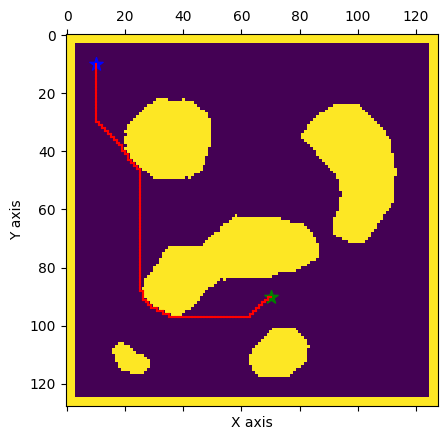

In [22]:
# Load grid map
image = Image.open("map0.png").convert('L')
grid_map = np.array(image.getdata()).reshape(image.size[0], image.size[1]) / 255
# Binarize the image
grid_map[grid_map > 0.5] = 1
grid_map[grid_map <= 0.5] = 0
# Invert colors to make 0 -> free and 1 -> occupied
grid_map = (grid_map * -1) + 1
# Show grid map
plt.matshow(grid_map)

start = [10, 10]
goal = [90, 70] 

path, cost = A_star_grid(grid_map, start, goal)

print("Path cost:", cost)
print("Path:", path)

plt.xlabel('X axis')
plt.ylabel('Y axis')

# Plot the A* path
for i in range(len(path)-1):
    x1, y1 = path[i]
    x2, y2 = path[i + 1]
    plt.plot([y1, y2], [x1, x2], color='red')

# Plot start and goal points
plt.scatter(start[1], start[0], color='blue', marker='*', s=100, label="Start")
plt.scatter(goal[1], goal[0], color='green', marker='*', s=100, label="Goal")


Path cost: 632.0
Path: [(8, 31), (9, 31), (10, 31), (11, 31), (12, 31), (13, 31), (14, 31), (15, 31), (16, 31), (17, 31), (18, 31), (19, 31), (20, 31), (21, 31), (22, 31), (22, 30), (22, 29), (22, 28), (22, 27), (22, 26), (23, 26), (23, 25), (24, 25), (25, 25), (26, 25), (27, 25), (28, 25), (29, 25), (30, 25), (31, 25), (32, 25), (33, 25), (33, 26), (33, 27), (33, 28), (33, 29), (33, 30), (33, 31), (33, 32), (33, 33), (33, 34), (33, 35), (33, 36), (33, 37), (33, 38), (33, 39), (33, 40), (33, 41), (33, 42), (33, 43), (33, 44), (33, 45), (33, 46), (33, 47), (33, 48), (33, 49), (33, 50), (33, 51), (33, 52), (33, 53), (33, 54), (33, 55), (32, 55), (31, 55), (30, 55), (29, 55), (28, 55), (27, 55), (26, 55), (25, 55), (24, 55), (23, 55), (23, 56), (22, 56), (22, 57), (22, 58), (22, 59), (22, 60), (22, 61), (22, 62), (22, 63), (22, 64), (22, 65), (23, 65), (23, 66), (24, 66), (25, 66), (26, 66), (27, 66), (28, 66), (29, 66), (30, 66), (31, 66), (32, 66), (33, 66), (33, 67), (33, 68), (33, 69)

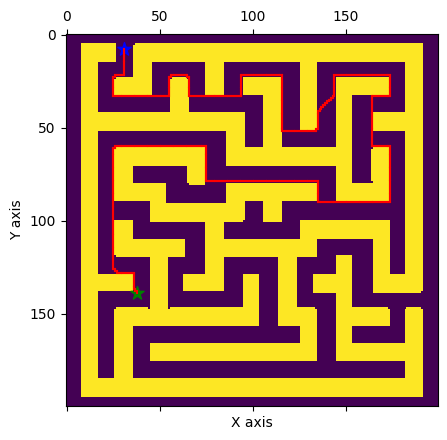

In [24]:
# Load grid map
image = Image.open("map2.png").convert('L')
grid_map = np.array(image.getdata()).reshape(image.size[0], image.size[1]) / 255
# Binarize the image
grid_map[grid_map > 0.5] = 1
grid_map[grid_map <= 0.5] = 0
# Invert colors to make 0 -> free and 1 -> occupied
grid_map = (grid_map * -1) + 1
# Show grid map
plt.matshow(grid_map)

start = [8, 31]
goal = [139, 38] 

path, cost = A_star_grid(grid_map, start, goal)

print("Path cost:", cost)
print("Path:", path)

plt.xlabel('X axis')
plt.ylabel('Y axis')

# Plot the A* path
for i in range(len(path)-1):
    x1, y1 = path[i]
    x2, y2 = path[i + 1]
    plt.plot([y1, y2], [x1, x2], color='red')

# Plot start and goal points
plt.scatter(start[1], start[0], color='blue', marker='*', s=100, label="Start")
plt.scatter(goal[1], goal[0], color='green', marker='*', s=100, label="Goal")